In [55]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils.util import *
import seaborn as sns
sns.set_theme()
sns.set_style("darkgrid")
# sns.set_context("paper")
sns.set_context("talk")

In [56]:
ctx_order = 'first'
ctx_order_str = 'ctxF'
analyze_name = 'proportions'

In [57]:
with open('../../results/%s_results_mlp.P' %(analyze_name), 'rb') as f:
    mlp_results = pickle.load(f)

with open('../../results/%s_%s_results_rnn.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results = pickle.load(f)

with open('../../results/%s_%s_results_rnncell.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnncell_results = pickle.load(f)

with open('../../results/%s_results_stepwisemlp.P' %(analyze_name), 'rb') as f:
    swmlp_results = pickle.load(f)

In [58]:
mlp_runs     = dict_to_list(mlp_results, analyze_name)
rnn_runs     = dict_to_list(rnn_results, analyze_name)
rnncell_runs = dict_to_list(rnncell_results, analyze_name)
swmlp_runs   = dict_to_list(swmlp_results, analyze_name)
mlp_runs.keys()

dict_keys(['hiddens_ctxs', 'p_pies', 'ps', 'n'])

In [59]:
hiddens_ctxs_mlp = np.asarray(mlp_runs['hiddens_ctxs']) # [run, checkpoints, n_ctxs, n_trials, hidd_dim]
p_pies_mlp = np.asarray(mlp_runs['p_pies']) # [run, checkpoints, n_ctxs, hidd_dim]
ps_mlp = np.asarray(mlp_runs['ps']) # [run, checkpoints, n_ctxs, hidd_dim]
n_mlp =  np.asarray(mlp_runs['n']) # [run, checkpoints, n_ctxs, hidd_dim]
n_runs, n_cps, _,  hidd_dim = n_mlp.shape
print(n_runs, n_cps, hidd_dim)


hiddens_ctxs_swmlp = np.asarray(swmlp_runs['hiddens_ctxs'])
p_pies_swmlp = np.asarray(swmlp_runs['p_pies'])
ps_swmlp = np.asarray(swmlp_runs['ps']) 
n_swmlp =  np.asarray(swmlp_runs['n']) 

20 21 128


In [60]:
def pie_bar_chart_data(pies):
    n_ctxs = pies.shape[0]
    n_hidd = pies.shape[1]
    ctxs = np.zeros(n_ctxs+2) # ctxs[-1] refers to none, and ctxs[-2] to mixed

    for i in range(n_hidd):
        ctx = pies[:,i]
        if  not np.any(ctx):
            ctxs[-1]+=1
        elif np.sum(ctx)>1:
            ctxs[-2]+=1
        else:
            idx = np.where(ctx) # this finds which context is 1
            ctxs[idx]+=1
        
    labels = []
    for ctx in range(n_ctxs):
        labels.append('ctx%s' %(ctx))
    labels.append('mixed')
    labels.append('none')
    
    return ctxs, labels

In [61]:
w_cp = -1 # last checkpoint, w stands for which 
w_run = 15
if w_run==-1:
    run_label = 'Last'
else:
    run_label = '#%s' %(w_run)

(20, 2, 128)
(20, 2, 128)


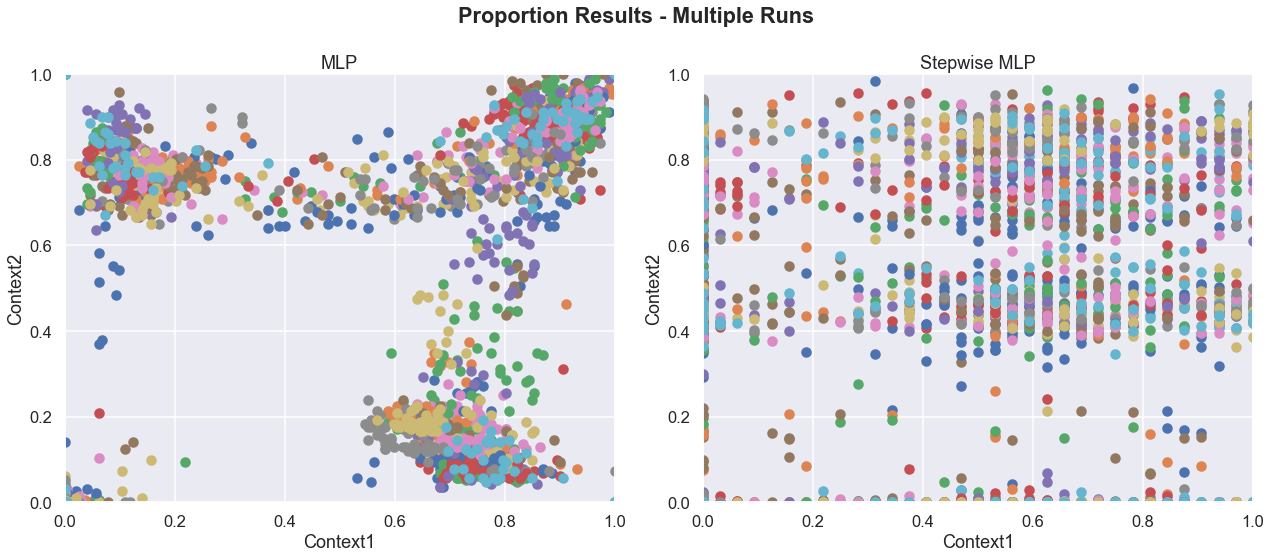

In [62]:
fig, axs = plt.subplots(1, 2, figsize=[18,8])

ps = ps_mlp
ps = ps[:,w_cp,:,:]
print(ps.shape)
ax = axs[0]
for run in range(n_runs):
    # colors shows different runs
    ax.scatter(ps[run][0], ps[run][1])
ax.set_title('MLP')

ps = ps_swmlp
ps = ps[:,w_cp,:,:]
print(ps.shape)
ax = axs[1]
for run in range(n_runs):
    # colors shows different runs
    ax.scatter(ps[run][0], ps[run][1])
ax.set_title('Stepwise MLP')

for ax in axs:
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('Context1')
    ax.set_ylabel('Context2')
    

fig.suptitle('Proportion Results - Multiple Runs', fontweight='bold')
plt.tight_layout()
fig_str = 'proportion_results_both_mlps_face_scatter'
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
            bbox_inches = 'tight', pad_inches = 0)
fig.savefig(('../../figures/' + fig_str + '.png'), 
            bbox_inches = 'tight', pad_inches = 0)


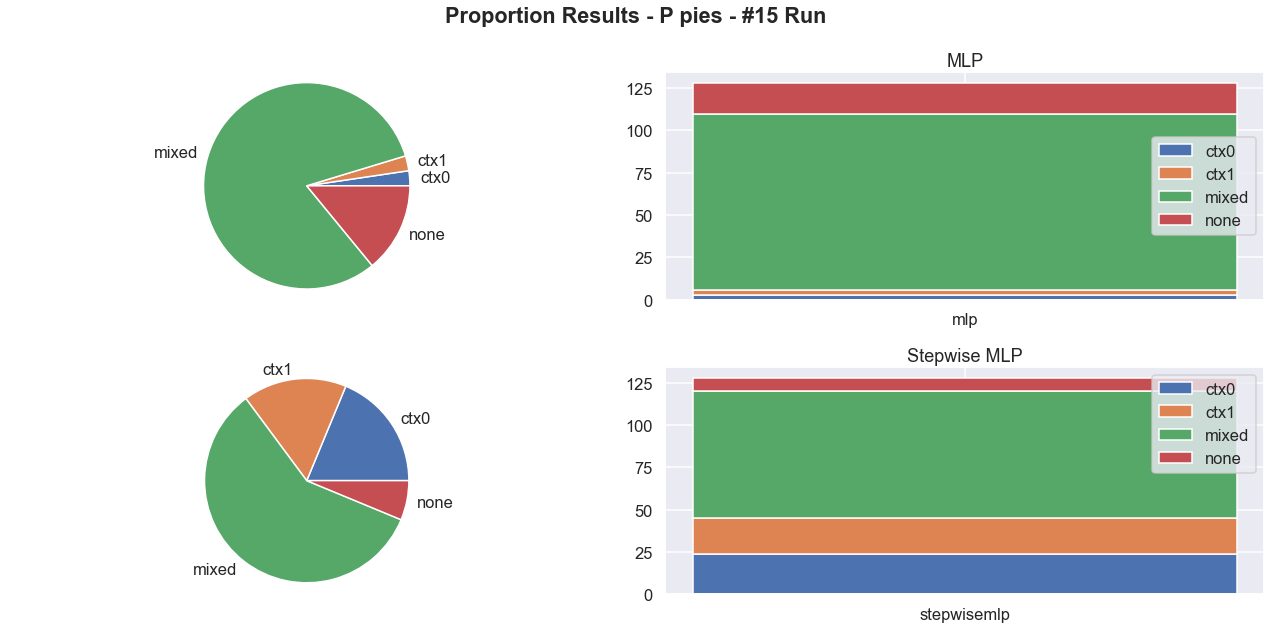

In [63]:
fig, axs = plt.subplots(2, 2, figsize=[18,9])

p_pies = p_pies_mlp
p_pies = p_pies[w_run,w_cp,:,:]
ctxs, labels = pie_bar_chart_data(p_pies)
ax = axs[0][0]
ax.pie(ctxs, labels=labels)#, autopct='%1.1f%%')#, shadow=True)#, startangle=90)
ax.axis('equal')
ax = axs[0][1]
model = 'mlp'
for ctx in range(ctxs.shape[0]):
        ax.bar(model, ctxs[ctx], bottom = np.sum(ctxs[:ctx]))
ax.legend(labels)
ax.set_title('MLP')

p_pies = p_pies_swmlp
p_pies = p_pies[w_run,w_cp,:,:]
ctxs, labels = pie_bar_chart_data(p_pies)
ax = axs[1][0]
ax.pie(ctxs, labels=labels)#, autopct='%1.1f%%')#, shadow=True)#, startangle=90)
ax.axis('equal')
ax = axs[1][1]
model = 'stepwisemlp'
for ctx in range(ctxs.shape[0]):
        ax.bar(model, ctxs[ctx], bottom = np.sum(ctxs[:ctx]))
ax.legend(labels)
ax.set_title('Stepwise MLP')

fig.suptitle('Proportion Results - P pies - %s Run' %(run_label), fontweight='bold')
plt.tight_layout()
fig_str = 'proportion_results_both_mlps_face_p_pies'
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
        bbox_inches = 'tight', pad_inches = 0)
fig.savefig(('../../figures/' + fig_str + '.png'), 
            bbox_inches = 'tight', pad_inches = 0)

# hidden units selectivity 
# proportion of hidden units that were active at all (even one trial) for each context
# we have ... many hiddens that were active for both (mixed), ... many units that were active for ctx1, so on so forth

In [64]:
def calc_hidd_sens(hidds_act):
    n_runs, n_cps, n_ctxs, n_hidd = hidds_act.shape
    ctxs = np.zeros([n_runs, n_cps, n_ctxs+2]) # ctxs[-1] refers to none, and ctxs[-2] to mixed
    for cp in range(n_cps):
        for r in range(n_runs):
            for i in range(n_hidd):
                ctx = hidds_act[r,cp,:,i] # [n_ctxs]
                # print(ctx)
                # print(n[r,cp,:,i])
                if  not np.any(ctx): # none
                    ctxs[r,cp,-1]+=1
                elif np.sum(ctx)>1: # mixed
                    ctxs[r,cp,-2]+=1
                else:
                    idx = np.where(ctx) # this finds which context is 1
                    ctxs[r,cp,idx]+=1
    return ctxs

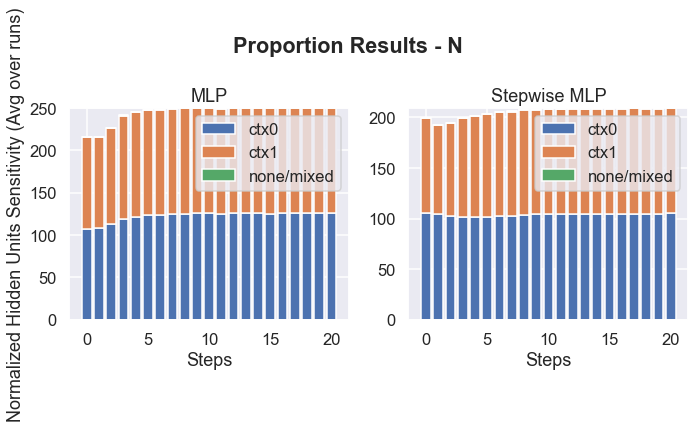

In [65]:
n_ctxs = 2

# plot
fig, axs = plt.subplots(1,2,figsize=[10, 5])
ax = axs
# labels
labels = []
for ctx in range(n_ctxs):
    labels.append('ctx%s' %(ctx))
if n_ctxs==2:
    labels.append('none/mixed')

n = n_mlp
ctxs = calc_hidd_sens(n)
m_ctxs = np.mean(ctxs, axis=0) # take avg over runs
ax = axs[0]
for ctx in range(m_ctxs.shape[1]):
    ax.bar(range(n_cps), m_ctxs[:,ctx], bottom = np.sum(m_ctxs[:,:ctx], axis=1))
ax.set_title('MLP')
ax.set_ylabel('Normalized Hidden Units Sensitivity (Avg over runs)')

n = n_swmlp
ctxs = calc_hidd_sens(n)
m_ctxs = np.mean(ctxs, axis=0) # take avg over runs
ax = axs[1]
for ctx in range(m_ctxs.shape[1]):
    ax.bar(range(n_cps), m_ctxs[:,ctx], bottom = np.sum(m_ctxs[:,:ctx], axis=1))
ax.set_title('Stepwise MLP')

for ax in axs:
    ax.legend(labels)
    ax.set_xlabel('Steps')
    
fig.suptitle('Proportion Results - N', fontweight='bold')
plt.tight_layout()
fig_str = 'proportion_results_both_mlps_face_n_overCPs'
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
              bbox_inches = 'tight', pad_inches = 0)
fig.savefig(('../../figures/' + fig_str + '.png'), 
            bbox_inches = 'tight', pad_inches = 0)


/Users/maryam/opt/anaconda3/envs/csls/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/maryam/opt/anaconda3/envs/csls/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


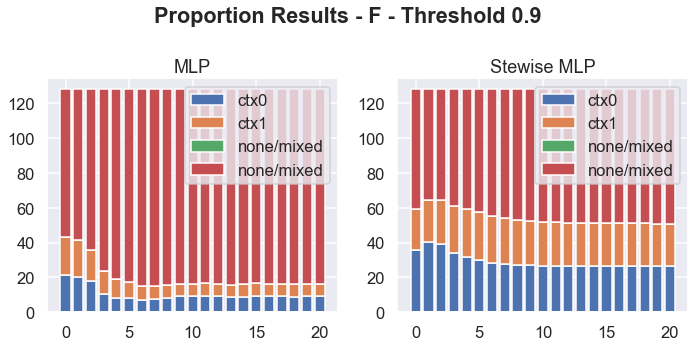

In [66]:
# first threshold, 
# then count
# then averge over those

# none here means none + mixed 
# given the overall activities for this hidd unit, the prop of trials that this unit was active that was above threshold (e.g, above 25%)
# n_ctxs=2, chance = 0.50, threshold = 95%

# labels
labels = []
for ctx in range(n_ctxs):
    labels.append('ctx%s' %(ctx))
if n_ctxs==2:
    n_thresh = 0.9
    labels.append('none/mixed')
    labels.append('none/mixed')


# plot
fig, axs = plt.subplots(1,2,figsize=[10, 5])

n = n_mlp
f = n > n_thresh
ctxs = calc_hidd_sens(f)
m_ctxs = np.mean(ctxs, axis=0) # take avg over runs
ax = axs[0]
for ctx in range(m_ctxs.shape[1]):
    ax.bar(range(n_cps), m_ctxs[:,ctx], bottom = np.sum(m_ctxs[:,:ctx], axis=1))
ax.set_title('MLP')

n = n_swmlp
f = n > n_thresh
ctxs = calc_hidd_sens(f)
m_ctxs = np.mean(ctxs, axis=0) # take avg over runs
ax = axs[1]
for ctx in range(m_ctxs.shape[1]):
    ax.bar(range(n_cps), m_ctxs[:,ctx], bottom = np.sum(m_ctxs[:,:ctx], axis=1))
ax.set_title('Stewise MLP')

for ax in axs:    
    ax.legend(labels)

plt.tight_layout()
fig.suptitle('Proportion Results - F - Threshold %s' %(n_thresh), fontweight='bold')
plt.tight_layout()
fig_str = 'proportion_results_both_mlps_face_f_overCPs'
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
              bbox_inches = 'tight', pad_inches = 0)
fig.savefig(('../../figures/' + fig_str + '.png'), 
            bbox_inches = 'tight', pad_inches = 0)

# n: [n_ctxs, hidden_dim] 
# normalized - for each ctx, for how many trials each unit was active (filtered by the threshold) 
# normalized by the overall activity of that unit for all ctx and trials
# we have ... many units that were active for ctx0 for more than n_threshold% of the trials


# normalized matrix

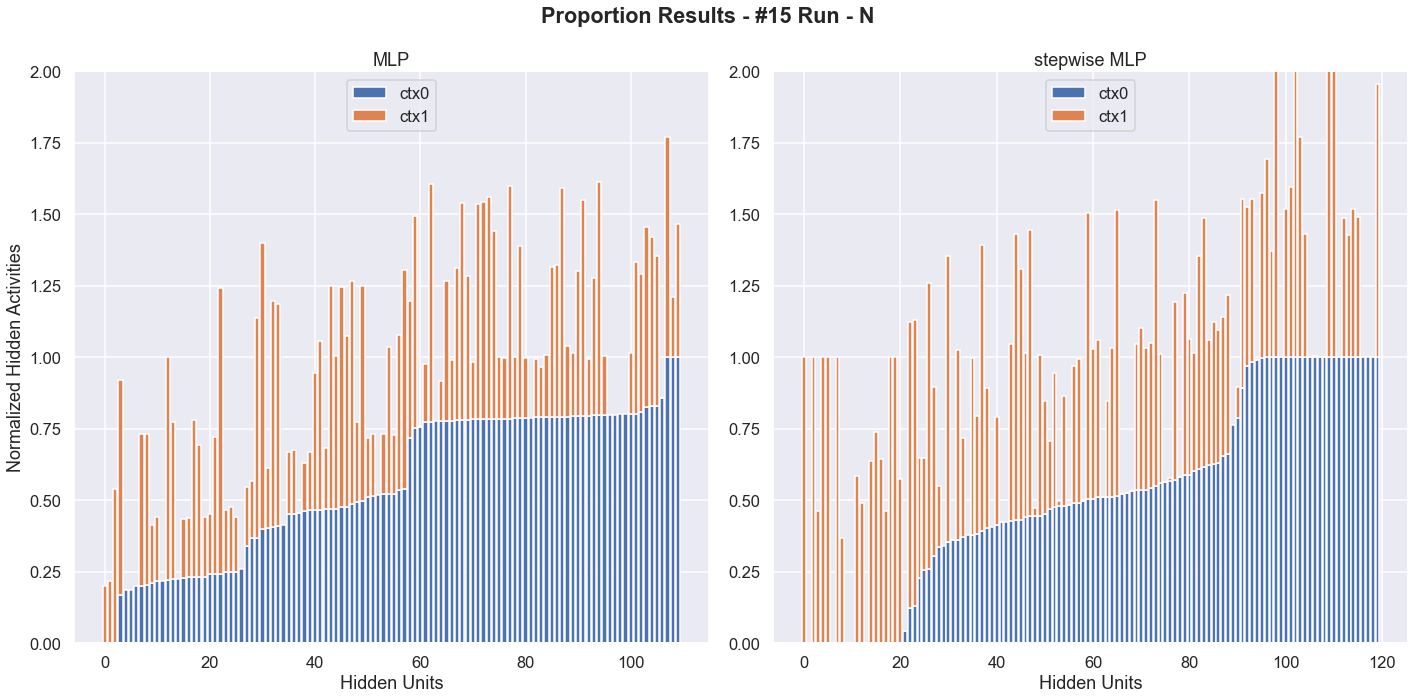

In [70]:
fig, axs = plt.subplots(1,2,figsize=[20, 10])

# plot 3P, using normalized p

sort_ind = 0

labels = []

for ctx in range(n_ctxs):
    labels.append('ctx%s' %(ctx))

# todo: sort the columns, based on the one context
n = n_mlp
_,_,n_ctxs,hidd_dim = n.shape
n = n[w_run, w_cp, :, :]
n[sort_ind, :] = np.sort(n[sort_ind, :])
ax = axs[0]
for ctx in range(n_ctxs):
    ax.bar(range(hidd_dim), n[ctx,:], bottom = np.sum(n[:ctx,:], axis=0))
ax.set_title('MLP')
ax.set_ylabel('Normalized Hidden Activities')

n = n_swmlp
_,_,n_ctxs,hidd_dim = n.shape
n = n[w_run, w_cp, :, :]
n[sort_ind, :] = np.sort(n[sort_ind, :])
ax = axs[1]
for ctx in range(n_ctxs):
    ax.bar(range(hidd_dim), n[ctx,:], bottom = np.sum(n[:ctx,:], axis=0))
ax.set_title('stepwise MLP')


for ax in axs:
    ax.set_ylim([0,2])
    ax.set_xlabel('Hidden Units')
    ax.legend(labels)

fig.suptitle('Proportion Results - %s Run - N' %(run_label), fontweight='bold')
plt.tight_layout()
fig_str = 'proportion_results_both_mlps_face_n'
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
              bbox_inches = 'tight', pad_inches = 0)]
fig.savefig(('../../figures/' + fig_str + '.png'), 
            bbox_inches = 'tight', pad_inches = 0)

# n: [n_ctxs, hidden_dim] 
# normalized - how much each unit is active for each ctx over trials 
# normalized by the overall activity of that unit for all ctx and trials
# x-axis shows each unit (128 hidden units total)
# y-axis shows normalized activity (number of trials) of that unit for each context over all the trials, 
# Q: what happens to those that were only active for the ctx1?